In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import globals as gl
from scipy.stats import pearsonr
import xarray as xr
import numpy as np
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')

experiment = 'EFC_learningEMG'
baseDir = os.path.join(gl.baseDir, experiment, 'coherence')

Base directory found: /cifs/diedrichsen/data/Chord_exp
Atlas directory found: /cifs/diedrichsen/data/Atlas_templates/fs_LR_32


In [2]:
info = pd.read_csv(os.path.join(baseDir, 'info.tsv'), sep='\t')
data = np.load(os.path.join(baseDir, 'mscohere.npz'))
coh = data['coh']

# Fisher z of sqrt coherence
z = np.arctanh(np.sqrt(np.clip(coh, 1e-12, 1 - 1e-12)))

f = data['f']

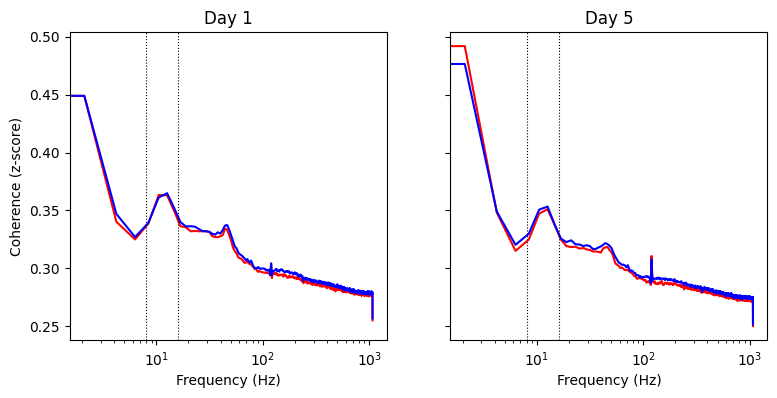

In [8]:
z_coh = xr.DataArray(z, dims=('trial', 'channel1', 'channel2', 'freq'))
z_coh = z_coh.assign_coords(subNum=('trial', info['subNum']),
                      day=('trial', info['day']),
                      chord=('trial', info['chord']),
                      chordID=('trial', info['chordID']))
z_coh = z_coh.groupby(['day', 'chord', 'subNum'], restore_coord_dims=True).mean('trial')

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))

for d, day in enumerate(z_coh.day):
    ax = axs[d]
    z_trained = z_coh.sel(day=day, chord='trained').mean(dim=('channel1','channel2','subNum'))
    z_untrained = z_coh.sel(day=day, chord='untrained').mean(dim=('channel1','channel2','subNum'))
    ax.plot(f, z_trained, 'red', label='trained' if d==0 else None)
    ax.plot(f, z_untrained, 'blue', label='untrained' if d==0 else None)
    ax.axvline(8, linestyle=':', color='black', lw=.8)
    ax.axvline(16, linestyle=':', color='black', lw=.8)
    ax.set_title(f'Day {int(day)}')
    ax.set_xscale('log')
    ax.set_xlabel('Frequency (Hz)')
    if d == 0:
        ax.set_ylabel('Coherence (z-score)')

plt.show()

In [16]:
mask = np.tri(10, k=-1, dtype=bool)
z_coh_pattern = z_coh.values[mask]


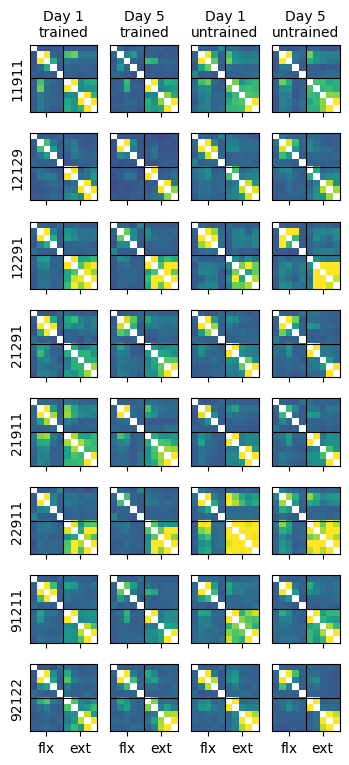

In [43]:
mask = (f > 8) & (f < 16)
coh = {'sn': [], 'chord': [], 'corr': []}
da = xr.DataArray(z, dims=('trial', 'channel1', 'channel2', 'freq'))
da = da.assign_coords(sn=('trial', info['subNum']),
                      day=('trial', info['day']),
                      chord=('trial', info['chord']),
                      chordID=('trial', info['chordID']))
z_alpha = da.sel(freq=mask).mean('freq')
z_alpha = z_alpha.groupby(['sn', 'day', 'chord', 'chordID']).mean('trial')

fig, axs = plt.subplots(len(z_alpha.chordID), 4, figsize=(4, 9), sharex=True, sharey=True)

for d, day in enumerate(z_alpha.day):
    for c, chordID in enumerate(z_alpha.chordID):
        z_trained = np.nanmean(z_alpha.sel(chordID=chordID, chord='trained', day=day).values, axis=-1)
        z_untrained = np.nanmean(z_alpha.sel(chordID=chordID, chord='untrained', day=day).values, axis=-1)
        if np.nansum(z_trained) > 0:
            ax=axs[c, d]
            coh_trained = np.tanh(z_trained)**2
            ax.imshow(coh_trained, vmin=0, vmax=.25)
            ax.axhline(4.5, linestyle='-', color='black', lw=.8)
            ax.axvline(4.5, linestyle='-', color='black', lw=.8)
            ax.set_title(f'Day {int(day)}\ntrained', fontsize=10) if c==0 else None
        if np.nansum(z_untrained) > 0:
            ax=axs[c, d + 2]
            coh_untrained = np.tanh(z_untrained)**2
            ax.imshow(coh_untrained, vmin=0, vmax=.25)
            ax.axhline(4.5, linestyle='-', color='black', lw=.8)
            ax.axvline(4.5, linestyle='-', color='black', lw=.8)
            ax.set_title(f'Day {int(day)}\nuntrained', fontsize=10) if c==0 else None
        axs[c, 0].set_ylabel(int(chordID))
        axs[c, 0].set_yticks([])

    axs[-1, d].set_xticks([2, 7])
    axs[-1, d].set_xticklabels(['flx', 'ext'])

plt.show()

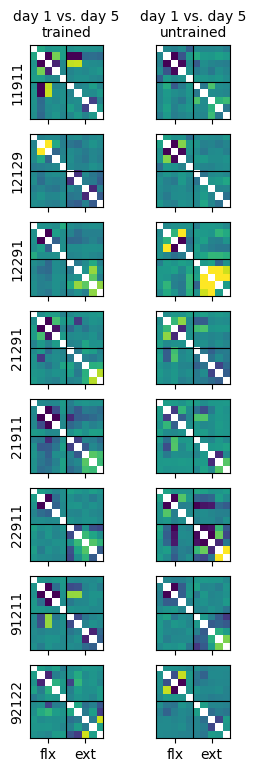

In [62]:
fig, axs = plt.subplots(len(z_alpha.chordID), 2, figsize=(3, 9), sharex=True, sharey=True)

for c, chordID in enumerate(z_alpha.chordID):
    coh_trained1 = np.tanh(z_alpha.sel(chordID=chordID, chord='trained', day=1).values)**2
    coh_trained5 = np.tanh(z_alpha.sel(chordID=chordID, chord='trained', day=5).values)**2
    coh_untrained1 = np.tanh(z_alpha.sel(chordID=chordID, chord='untrained', day=1).values)**2
    coh_untrained5 = np.tanh(z_alpha.sel(chordID=chordID, chord='untrained', day=5).values)**2
    coh_diff_trained = np.nanmean(coh_trained5 - coh_trained1, axis=-1)
    coh_diff_untrained = np.nanmean(coh_untrained5 - coh_untrained1, axis=-1)
    axs[c, 0].imshow(coh_diff_trained, vmin=-.1, vmax=.1)
    axs[c, 1].imshow(coh_diff_untrained, vmin=-.1, vmax=.1)
    axs[c, 0].set_ylabel(int(chordID))
    axs[c, 0].set_yticks([])

for ax in axs.flatten():
    ax.axhline(4.5, linestyle='-', color='black', lw=.8)
    ax.axvline(4.5, linestyle='-', color='black', lw=.8)

axs[0, 0].set_title(f'day 1 vs. day 5\ntrained', fontsize=10)
axs[0, 1].set_title(f'day 1 vs. day 5\nuntrained', fontsize=10)

axs[-1, 0].set_xticks([2, 7])
axs[-1, 1].set_xticklabels(['flx', 'ext'])

plt.show()

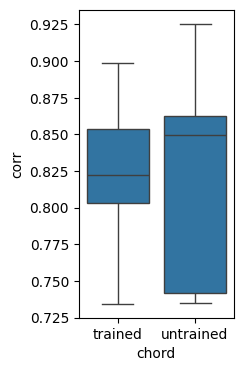

In [63]:
coh_alpha = np.tanh(z_alpha)**2
mask = np.tri(10, k=-1, dtype=bool)
for sn in z_alpha.sn:
    for chordID in z_alpha.chordID:
        coh_trained = coh_alpha.sel(sn=sn, chordID=chordID, chord='trained').values
        coh_untrained = coh_alpha.sel(sn=sn, chordID=chordID, chord='untrained').values
        if np.nansum(coh_trained) > 0:
            a = coh_trained[mask, 0]
            b = coh_trained[mask, 1]
            r, _ = pearsonr(a, b)
            coh['sn'].append(int(sn))
            coh['chord'].append('trained')
            coh['corr'].append(r)
        if np.nansum(coh_untrained) > 0:
            a = coh_untrained[mask, 0]
            b = coh_untrained[mask, 1]
            r, _ = pearsonr(a, b)
            coh['sn'].append(int(sn))
            coh['chord'].append('untrained')
            coh['corr'].append(r)

df = pd.DataFrame(coh)
df = df.groupby(['sn', 'chord']).mean(numeric_only=True).reset_index()

fig, ax = plt.subplots(figsize=(2, 4))
sb.boxplot(y='corr', x='chord', data=df, ax=ax, showfliers=False)

plt.show()
